<a href="https://colab.research.google.com/github/buzacott/frontiers_ecohydrology/blob/main/frontiers-ecohydrology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frontiers in Ecohydrology

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from calendar import monthrange

# Change default plot size
plt.rcParams["figure.figsize"] = (9,6)

In [71]:
# Datetime parser for variable dt lengths
def flx_date_parser(date):
    if(len(date)==4):
        pattern = '%Y'
    if(len(date)==6):
        pattern = '%Y%m'
    if(len(date)==8):
        pattern = '%Y%m%d'
    if(len(date)==12):
        pattern = '%Y%m%d%H%M'
    
    return dt.datetime.strptime(date, pattern)

## Load data from GitHub

The flux data is currently a combined file that contains the monthly FLUXNET2015 Tier 1 data. Can switch to daily but for experimenting monthly is fine.

In [123]:
flx = pd.read_csv('https://raw.githubusercontent.com/buzacott/frontiers_ecohydrology/main/data/fluxnet2015_combined_monthly_data.csv')
flx['TIMESTAMP'] = pd.to_datetime(flx['TIMESTAMP'])
# Split site ID into country and site name
flx[['Country', 'Site']] = flx['SITE_ID'].str.split('-', expand=True)
flx.head()

,TIMESTAMP,SITE_ID,TA_F,SW_IN_POT,SW_IN_F,LW_IN_F,VPD_F,PA_F,P_F,WS_F,...,H_RANDUNC,NEE_VUT_REF,RECO_NT_VUT_REF,GPP_NT_VUT_REF,PPFD_DIF,SW_DIF,LW_OUT,ET_F_MDS,Country,Site
0,2010-01-01,SN-Dhr,29.467,342.963,11.044,330.718,23.842,100.766,0.000,2.996,...,NaN,-7.40131,6.99884,14.3139,NaN,NaN,NaN,4.123013,SN,Dhr
1,2010-02-01,SN-Dhr,28.795,380.174,12.317,353.484,23.794,100.602,0.000,2.906,...,NaN,-7.42792,6.86155,14.2089,NaN,NaN,NaN,4.119353,SN,Dhr
2,2010-03-01,SN-Dhr,28.019,419.192,14.196,358.876,23.368,100.492,0.000,3.075,...,NaN,-7.40865,6.70299,14.0398,NaN,NaN,NaN,4.117739,SN,Dhr
3,2010-04-01,SN-Dhr,27.762,443.462,14.655,385.542,23.424,100.388,0.052,3.335,...,NaN,-7.41212,6.65065,13.9931,NaN,NaN,NaN,4.117146,SN,Dhr
4,2010-05-01,SN-Dhr,27.221,449.791,15.075,402.832,23.192,100.414,0.000,3.080,...,NaN,-7.40131,6.54057,13.8779,NaN,NaN,NaN,4.116474,SN,Dhr


BADM (Biological, Ancillary, Disturbance, and Metadata) contain Site General Info, Canopy Height, and Variable Info

In [124]:
badm = pd.read_csv('https://raw.githubusercontent.com/buzacott/frontiers_ecohydrology/main/data/fluxnet2015_badm_monthly.csv')
badm.head()

,SITE_ID,GROUP_ID,VARIABLE_GROUP,VARIABLE,DATAVALUE
0,AR-SLu,14214,GRP_CLIM_AVG,MAP,400
1,AR-SLu,27000554,GRP_COUNTRY,COUNTRY,Argentina
2,AR-SLu,81739,GRP_DOI,DOI,10.18140/FLX/1440191
3,AR-SLu,81739,GRP_DOI,DOI_DATAPRODUCT,FLUXNET2015
4,AR-SLu,30007072,GRP_DOI_CONTRIBUTOR,DOI_CONTRIBUTOR_NAME,Alfredo Garcia


In [125]:
badm.VARIABLE_GROUP.unique()

array(['GRP_CLIM_AVG', 'GRP_COUNTRY', 'GRP_DOI', 'GRP_DOI_CONTRIBUTOR',
       'GRP_DOI_ORGANIZATION', 'GRP_HEADER', 'GRP_IGBP', 'GRP_LOCATION',
       'GRP_NETWORK', 'GRP_REFERENCE_PAPER', 'GRP_TEAM_MEMBER',
       'GRP_URL_FLUXNET', 'GRP_UTC_OFFSET', 'GRP_HEIGHTC', 'GRP_VAR_INFO',
       'GRP_DOM_DIST_MGMT', 'GRP_FLUX_MEASUREMENTS', 'GRP_RESEARCH_TOPIC',
       'GRP_SITE_CHAR', 'GRP_SITE_DESC', 'GRP_SITE_FUNDING',
       'GRP_TOWER_POWER', 'GRP_TOWER_TYPE', 'GRP_URL',
       'GRP_ACKNOWLEDGEMENT', 'GRP_LAND_OWNERSHIP'], dtype=object)

Extract key variables

In [126]:
# International Geosphere-Biosphere Programme land use code
# https://fluxnet.org/data/badm-data-templates/igbp-classification/
landuse = badm.query('VARIABLE_GROUP == "GRP_IGBP"') \
              .pivot(index=['SITE_ID', 'GROUP_ID'],
                     columns = 'VARIABLE',
                     values = 'DATAVALUE') \
              .reset_index()
# Lat/lon
location = badm.query('VARIABLE_GROUP == "GRP_LOCATION"') \
               .pivot(index=['SITE_ID', 'GROUP_ID'],
                      columns = 'VARIABLE',
                      values = 'DATAVALUE') \
               .reset_index()
# Some duplicates, some sites move. Filter them for now
location.drop_duplicates(subset='SITE_ID', inplace=True)

# Canopy height
canopy_height = badm.query('VARIABLE_GROUP == "GRP_HEIGHTC"') \
                    .pivot(index=['SITE_ID', 'GROUP_ID'],
                           columns = 'VARIABLE',
                           values = 'DATAVALUE') \
                    .reset_index() \
                    .rename({'HEIGHTC_DATE': 'TIMESTAMP'}, axis=1) \
                    .infer_objects()
canopy_height['TIMESTAMP'] = [flx_date_parser(d) for d in canopy_height['TIMESTAMP']]

In [127]:
# Update dtypes, infer_objects() does not work
def update_dtypes(df):
  cols = df.columns
  for c in cols:
      if c is not 'TIMESTAMP':
        try:
            df[c] = pd.to_numeric(df[c])
        except:
            pass
  return df

location = update_dtypes(location)
canopy_height = update_dtypes(canopy_height)

In [128]:
# Create a canopy height value for each timestep
# Some site have many values, others only 1
canopy_height_full = flx[['TIMESTAMP', 'SITE_ID']] \
  .merge(canopy_height[['TIMESTAMP', 'SITE_ID', 'HEIGHTC']],
         how='left')
canopy_height_full['HEIGHTC'] = canopy_height_full.groupby('SITE_ID', sort=False)['HEIGHTC'].apply(lambda x: x.ffill().bfill())

Add in NDVI that has been extracted from MOD13Q1.061 via GEE

https://colab.research.google.com/drive/1pF-sdizmByxEHvE4rEyIz-QT-3P717kx?usp=sharing

In [129]:
ndvi = pd.read_csv('https://raw.githubusercontent.com/buzacott/frontiers_ecohydrology/main/data/fluxnet2015_ndvi_monthly.csv')
ndvi['TIMESTAMP'] = pd.to_datetime(ndvi['TIMESTAMP'])
ndvi.head()

,SITE_ID,TIMESTAMP,NDVI
0,AR-SLu,2000-02-01,0.57160
1,AR-SLu,2000-03-01,0.59320
2,AR-SLu,2000-04-01,0.57055
3,AR-SLu,2000-05-01,0.50160
4,AR-SLu,2000-06-01,0.44330


### Merge data frames together

In [131]:
# Join ndvi into df
df = flx.merge(ndvi,
               how='left',
               left_on=['TIMESTAMP', 'SITE_ID'],
               right_on=['TIMESTAMP', 'SITE_ID']) \
       .merge(landuse[['SITE_ID', 'IGBP']],
              how='left',
              left_on='SITE_ID',
              right_on='SITE_ID') \
       .merge(location[['SITE_ID', 'LOCATION_LAT', 'LOCATION_LONG']],
              left_on='SITE_ID',
              right_on='SITE_ID') \
       .merge(canopy_height_full,
              left_on=['TIMESTAMP', 'SITE_ID'],
              right_on=['TIMESTAMP', 'SITE_ID'])

df.set_index('TIMESTAMP', inplace=True)
df

,SITE_ID,TA_F,SW_IN_POT,SW_IN_F,LW_IN_F,VPD_F,PA_F,P_F,WS_F,USTAR,...,SW_DIF,LW_OUT,ET_F_MDS,Country,Site,NDVI,IGBP,LOCATION_LAT,LOCATION_LONG,HEIGHTC
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2010-01-01,SN-Dhr,29.467,342.963,11.044,330.718,23.842,100.766,0.000,2.996,NaN,...,NaN,NaN,4.123013,SN,Dhr,0.20875,SAV,15.40278,-15.43222,1.58
2010-02-01,SN-Dhr,28.795,380.174,12.317,353.484,23.794,100.602,0.000,2.906,NaN,...,NaN,NaN,4.119353,SN,Dhr,0.21285,SAV,15.40278,-15.43222,1.58
2010-03-01,SN-Dhr,28.019,419.192,14.196,358.876,23.368,100.492,0.000,3.075,NaN,...,NaN,NaN,4.117739,SN,Dhr,0.18560,SAV,15.40278,-15.43222,1.58
2010-04-01,SN-Dhr,27.762,443.462,14.655,385.542,23.424,100.388,0.052,3.335,NaN,...,NaN,NaN,4.117146,SN,Dhr,0.18870,SAV,15.40278,-15.43222,1.58
2010-05-01,SN-Dhr,27.221,449.791,15.075,402.832,23.192,100.414,0.000,3.080,NaN,...,NaN,NaN,4.116474,SN,Dhr,0.17735,SAV,15.40278,-15.43222,1.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-08-01,BR-Sa3,25.605,406.055,181.901,411.642,9.201,98.732,2.837,1.804,NaN,...,NaN,NaN,2.163218,BR,Sa3,0.86445,EBF,-3.01803,-54.97144,25.00
2004-09-01,BR-Sa3,26.004,429.912,204.215,412.823,9.329,98.587,3.696,2.018,NaN,...,NaN,NaN,2.172189,BR,Sa3,NaN,EBF,-3.01803,-54.97144,25.00
2004-10-01,BR-Sa3,26.708,440.106,217.381,416.859,10.586,98.473,2.546,2.127,NaN,...,NaN,NaN,2.177463,BR,Sa3,0.73560,EBF,-3.01803,-54.97144,25.00


# Exploratory data analysis

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


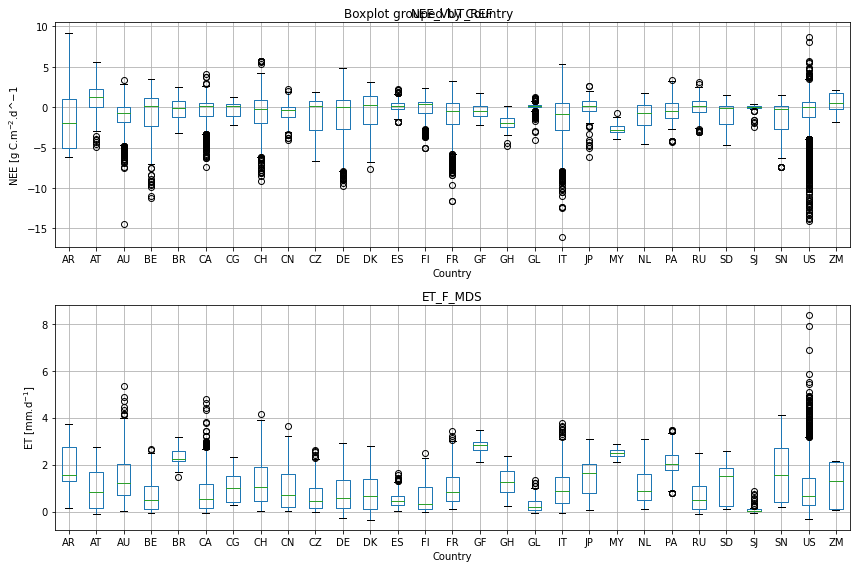

In [ ]:
# Boxplot of NEE and ET by country
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,8)) 

df.boxplot('NEE_VUT_REF', by='Country', figsize=(9,6), ax=ax0)
ax0.set_ylabel('NEE [g C.m$^{-2}$.d^${-1}$')

df.boxplot('ET_F_MDS', by='Country', figsize=(9,6), ax=ax1)
ax1.set_ylabel('ET [mm.d$^{-1}$]')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


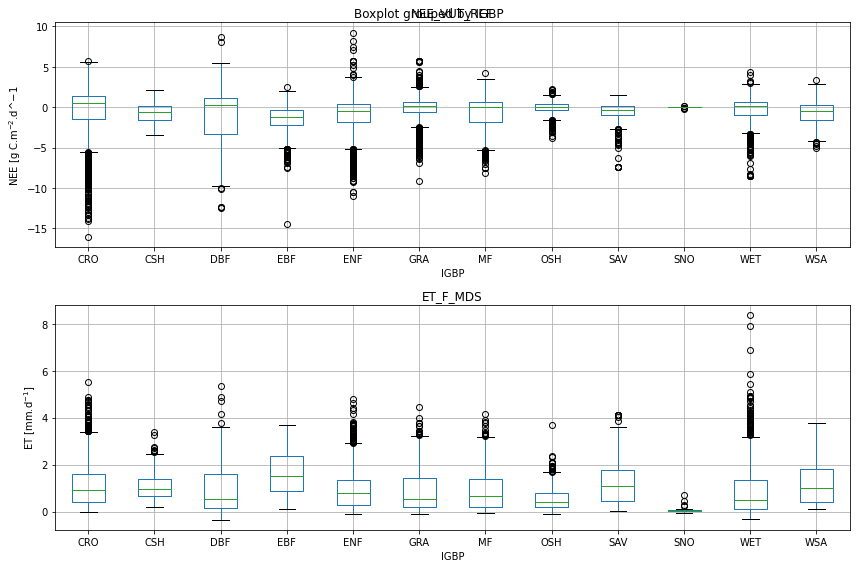

In [133]:
# https://fluxnet.org/data/badm-data-templates/igbp-classification/
# Boxplot of NEE and ET by land use
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,8)) 

df.boxplot('NEE_VUT_REF', by='IGBP', figsize=(9,6), ax=ax0)
ax0.set_ylabel('NEE [g C.m$^{-2}$.d^${-1}$')

df.boxplot('ET_F_MDS', by='IGBP', figsize=(9,6), ax=ax1)
ax1.set_ylabel('ET [mm.d$^{-1}$]')

plt.tight_layout()
plt.show()

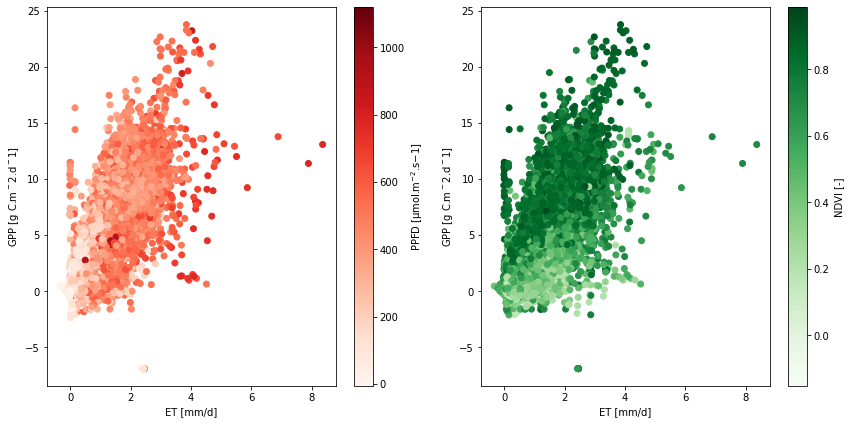

In [ ]:
# ET vs GPP, coloured by PAR and NDVI
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12, 6))

fig0 = ax0.scatter(df['ET_F_MDS'], df['GPP_NT_VUT_REF'], c=df['PPFD_IN'], cmap='Reds')
ax0.set_xlabel('ET [mm/d]')
ax0.set_ylabel('GPP [g C.m${^-2}$.d${^-1}$]')
cb0 = plt.colorbar(fig0, ax=ax0)
cb0.set_label('PPFD [µmol.m$^{-2}$.s${-1}$]')


fig1 = ax1.scatter(df['ET_F_MDS'], df['GPP_NT_VUT_REF'], c=df['NDVI'], cmap='Greens')
ax1.set_xlabel('ET [mm/d]')
ax1.set_ylabel('GPP [g C.m${^-2}$.d${^-1}$]')
cb1 = plt.colorbar(fig1, ax=ax1)
cb1.set_label('NDVI [-]')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


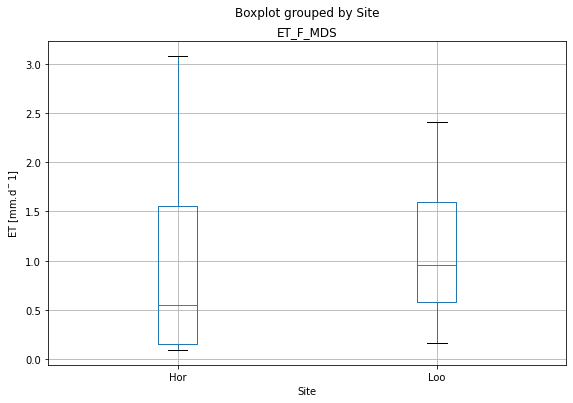

In [ ]:
# Look at NL sites
df[df.Country=='NL'].boxplot('ET_F_MDS', by='Site')
plt.ylabel('ET [mm.d${^-1}$]')
plt.show()

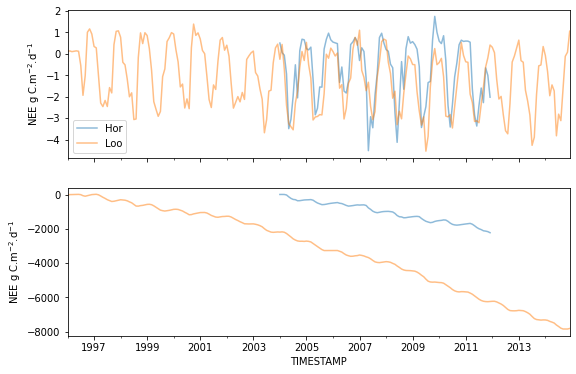

In [ ]:
# Carbon accumulation over time
fig, (ax0, ax1) = plt.subplots(2,1, sharex=True)

grouped = df[df.Country=='NL'].groupby('Site')

for name, group in grouped:
    # Multiply by days in month for better approx of cumsum
    group['NEE_VUT_REF_CS'] = np.cumsum(group['NEE_VUT_REF'] * np.array([monthrange(x.year, x.month)[1] for x in group.index]))
  
    group.plot(y='NEE_VUT_REF', ax=ax0, alpha=0.5)
    group.plot(y='NEE_VUT_REF_CS', ax=ax1, alpha=0.5, legend=False)

ax0.legend(grouped.groups.keys())
ax0.set_ylabel('NEE g C.m$^{-2}$.d$^{-1}$')
ax1.set_ylabel('NEE g C.m$^{-2}$.d$^{-1}$')

plt.show()

## Interactive plot

In [149]:
def run_scatter(x, y, z, lm=True):
  # Select vars
  X = df[x]
  Y = df[y]
  Z = df[z]
  
  # Remove NaN values
  idx = np.isfinite(X) & np.isfinite(Y)
  X = X[idx]
  Y = Y[idx]
  Z = Z[idx]

  fig = plt.figure()
  
  # Add scatter plot
  plt.scatter(X, Y, c=Z, alpha=0.5)

  # Add regression line
  if lm:
    m, b = np.polyfit(X, Y, deg=1)
    Y_pred = X*m + b
    r2 = np.corrcoef(X, Y)[1,0]**2
    plt.plot(X, Y_pred, color='r', label=f'$y = {m:.2f}x {b:+.2f}, R^2 = {r2:.2f}$')

  # Add plot info
  plt.xlabel(x)
  plt.ylabel(y)
  cb = plt.colorbar()
  cb.set_label(z)
  plt.legend()

  plt.show()

# Filter to numeric only
df_sub = df.select_dtypes(include=[np.number])

widgets.interact(run_scatter,
                 x = df_sub,
                 y = df_sub,
                 z = df_sub)

interactive(children=(Dropdown(description='x', options=('TA_F', 'SW_IN_POT', 'SW_IN_F', 'LW_IN_F', 'VPD_F', '…

<function __main__.run_scatter>

### Using categorical data

In [146]:
def run_boxplot(x, y):
  df.boxplot(x, by=y)
  plt
  plt.show()

widgets.interact(run_boxplot,
                 x = df.dtypes[df.dtypes==np.number].index,
                 y = df.dtypes[df.dtypes!=np.number].index)

interactive(children=(Dropdown(description='x', options=('TA_F', 'SW_IN_POT', 'SW_IN_F', 'LW_IN_F', 'VPD_F', '…

<function __main__.run_boxplot>